<a href="https://colab.research.google.com/github/ravindrabharathi/LiveAI/blob/main/AgriAI/AgriAI_ResNet50_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detection of weeds using Deep Learning 

>Weeds compete with productive
crops or pasture, they can be
poisonous, distasteful, produce burrs,
thorns or otherwise interfere with
the use and management of desirable
plants by contaminating harvests or
interfering with livestock.
Weeds also compete with crops for
space, nutrients, water and light
thereby disallowing edible crops to
grow healthily.

> According to Wikipedia, smaller,
slower growing seedlings are more
susceptible than those that are
larger and more vigorous. Onions are
one of the most vulnerable, because
they are slow to germinate and
produce slender, upright stems.

> Robotic weed control has seen increased research of late with its potential for boosting productivity in
agriculture. Majority of works focus on developing robotics for croplands, ignoring the weed
management problems facing rangeland stock farmers. Perhaps the greatest obstacle to widespread
uptake of robotic weed control is the robust classification of weed species in their natural environment.

> [The DeepWeeds dataset](https://github.com/AlexOlsen/DeepWeeds) consists of 17,509 labelled images of eight nationally significant weed
species native to eight locations across northern Australia.
In order to solve this Agriculture AI problem, we’re going to train a classifier that’s going to take in
images and predict the category it belongs to. 

Import necessary Modules 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Concatenate,Lambda,Activation,Input,Dropout
 
from tensorflow.keras.optimizers import Adam,SGD
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.data import Dataset

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

import math



### Install tf_utils package for deep_weeds 

In [2]:
!pip install --upgrade git+https://github.com/ravindrabharathi/tf_utils@deep_weeds 

  Cloning https://github.com/ravindrabharathi/tf_utils (to revision deep_weeds) to /tmp/pip-req-build-wg1l789g
  Running command git clone -q https://github.com/ravindrabharathi/tf_utils /tmp/pip-req-build-wg1l789g
  Running command git checkout -b deep_weeds --track origin/deep_weeds
  Switched to a new branch 'deep_weeds'
  Branch 'deep_weeds' set up to track remote branch 'deep_weeds' from 'origin'.
  Created wheel for tf-utils: filename=tf_utils-0.3-cp36-none-any.whl size=9629 sha256=9ca953313ef893f309a4ec6aeca6f97737f4dd157dff25f235dc722f9137c54c
  Stored in directory: /tmp/pip-ephem-wheel-cache-v5o1vjpd/wheels/9c/9c/8f/a54e3dbbb1451ca4a7cea3887c19b0be52891a74f298f86a38
Successfully built tf-utils


### Import data, transforms and Visualization modules from tf_utils

In [3]:
import tf_utils.data as ds 
import tf_utils.visualize as vz
import tf_utils.transform as tfm

### Mount Google Drive for to copy Images and labels 

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### copy images zip and labels csv from google drive 

In [5]:
!cp '/gdrive/My Drive/LiveAI/AgriAI/images.zip' '.'

In [6]:
!cp '/gdrive/My Drive/LiveAI/AgriAI/labels_deep_weeds.csv' '.'

### Unzip images to 'data' directory 

In [7]:
!mkdir data

In [8]:
!unzip -uq "images.zip" -d ./data

### Check number of images are correct in the data directory 

In [9]:
import os
file_list=os.listdir('./data')
len(file_list)

17509

### Read the labels into a dataframe 

In [10]:
data=pd.read_csv('labels_deep_weeds.csv')
data.head()

Filename  Label       Species
0  20160928-140314-0.jpg      0  Chinee apple
1  20160928-140337-0.jpg      0  Chinee apple
2  20160928-140731-0.jpg      0  Chinee apple
3  20160928-140747-0.jpg      0  Chinee apple
4  20160928-141107-0.jpg      0  Chinee apple

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17509 entries, 0 to 17508
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  17509 non-null  object
 1   Label     17509 non-null  int64 
 2   Species   17509 non-null  object
dtypes: int64(1), object(2)
memory usage: 410.5+ KB


### Create train, validation and test DataFrames 

In [12]:
train_df1,val_df,test_df=ds.get_train_val_test_df(data)


In [13]:
train_df1.head()

Filename  Label       Species
5476  20170920-114328-3.jpg      2   Parkinsonia
2966  20170718-100046-2.jpg      0  Chinee apple
5607  20170920-134648-2.jpg      2   Parkinsonia
5864  20170920-185253-1.jpg      2   Parkinsonia
1797  20170610-123756-0.jpg      1       Lantana

### Check that the dataframe shapes are as expected 60% train,20% validation and 20% Test split

In [14]:
train_df1.shape,val_df.shape,test_df.shape

((10505, 3), (3502, 3), (3502, 3))

### Print information about the data
-- How many Classes are Present 

-- What is the Count for each class

-- Plot a histogram of the class counts 



Class Mapping
-----------------
   Label         Species
0      0    Chinee apple
1      1         Lantana
2      2     Parkinsonia
3      3      Parthenium
4      4  Prickly acacia
5      5     Rubber vine
6      6       Siam weed
7      7      Snake weed
8      8        Negative
---------------------

Count per Species
-----------------
          Species  Total
0        Negative   9106
1    Chinee apple   1125
2       Siam weed   1074
3         Lantana   1064
4  Prickly acacia   1062
5     Parkinsonia   1031
6      Parthenium   1022
7      Snake weed   1016
8     Rubber vine   1009
---------------------



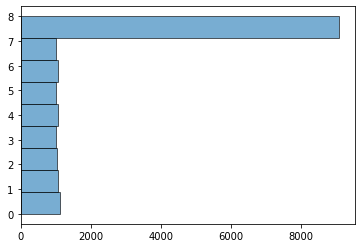

In [15]:
vz.visualize_data(data)

### Plot some sample images from each Class

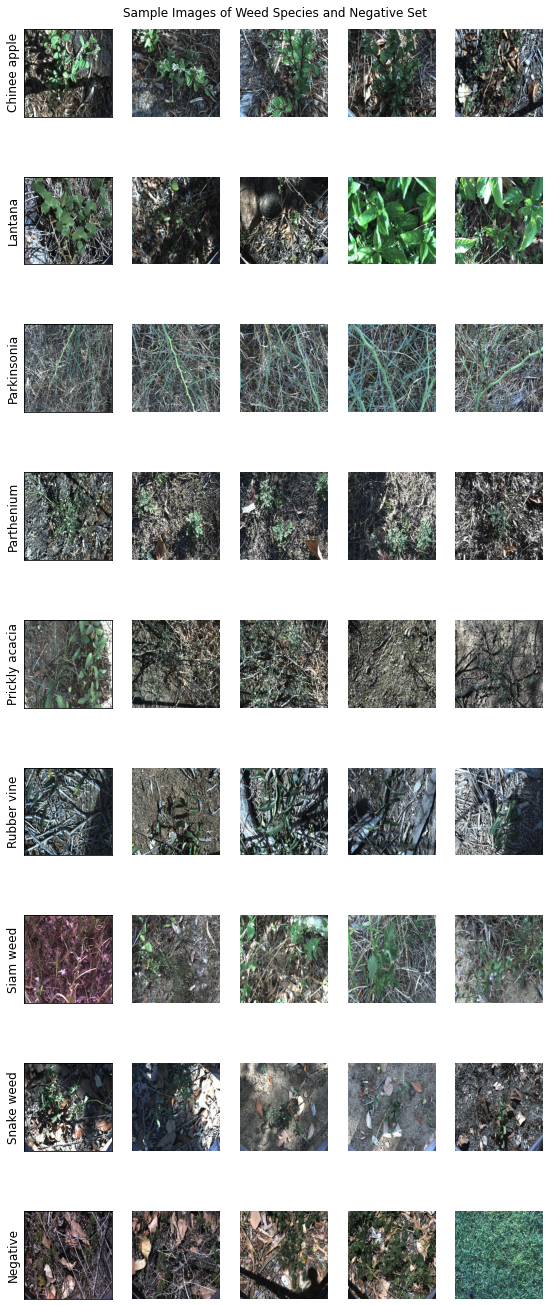

In [16]:
vz.show_image_sample(data_df=data,images_dir='./data')

### Print Class Name - Label Mapping 

In [17]:
class_map,species_names=ds.get_class_map_and_species_names(data)

In [18]:
print(class_map,'\n\n',species_names)

   Label         Species
0      0    Chinee apple
1      1         Lantana
2      2     Parkinsonia
3      3      Parthenium
4      4  Prickly acacia
5      5     Rubber vine
6      6       Siam weed
7      7      Snake weed
8      8        Negative 

 {0: 'Chinee apple', 1: 'Lantana', 2: 'Parkinsonia', 3: 'Parthenium', 4: 'Prickly acacia', 5: 'Rubber vine', 6: 'Siam weed', 7: 'Snake weed', 8: 'Negative'}


### Create tf records

In [19]:
ds.create_tf_records()


Generating ./tf_train/train.tfrecords
Finished 'convert_to_tfrecord' in 39.9876 secs
Done!
Generating ./tf_train/eval.tfrecords
Finished 'convert_to_tfrecord' in 20.0231 secs
Done!
Generating ./tf_train/test.tfrecords
Finished 'convert_to_tfrecord' in 18.0190 secs
Done!
Finished 'create_tf_records' in 78.0434 secs


### Create the train, validation and Test Datasets
Train dataset has distortions set to True and so the images will be augmented with Cutout and Random Horizontal Flip

In [20]:
train_ds=ds.get_train_ds(distort=True)
val_ds=ds.get_eval_ds()
test_ds=ds.get_test_ds()

distorting...
Finished 'get_tf_dataset_2' in 9.7387 secs
returning dataset for  2.3.0
Finished 'get_tf_dataset_in_batches' in 9.7394 secs
Finished 'get_train_ds' in 9.7395 secs
---parse batch -----
<dtype: 'uint8'> (None, None) Tensor("strided_slice:0", shape=(), dtype=int32)
Finished 'get_tf_dataset' in 0.0858 secs
returning dataset for  2.3.0
Finished 'get_tf_dataset_in_batches' in 0.0862 secs
Finished 'get_eval_ds' in 0.0862 secs
---parse batch -----
<dtype: 'uint8'> (None, None) Tensor("strided_slice:0", shape=(), dtype=int32)
Finished 'get_tf_dataset' in 0.0315 secs
returning dataset for  2.3.0
Finished 'get_tf_dataset_in_batches' in 0.0316 secs
Finished 'get_test_ds' in 0.0316 secs


### Plot some images /label pairs from Train, Validation and Test Dataset 

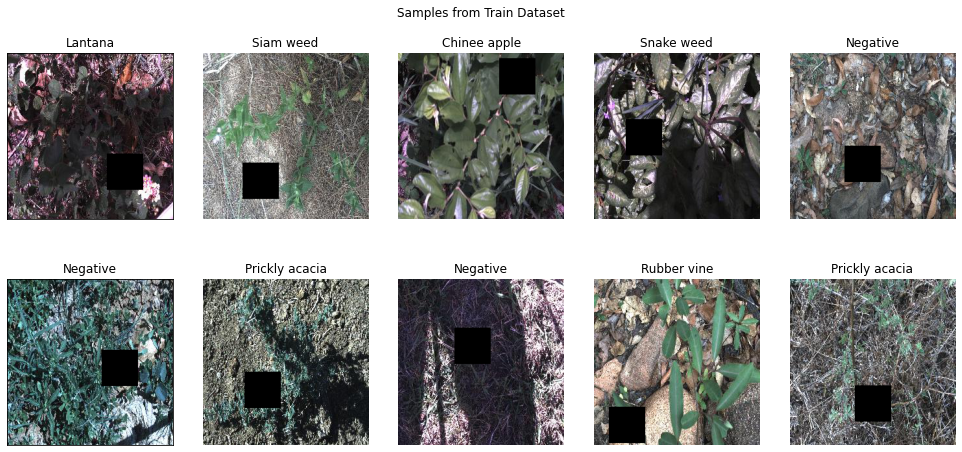

In [21]:
vz.plot_images_from_ds(train_ds,"Samples from Train Dataset",species_names)

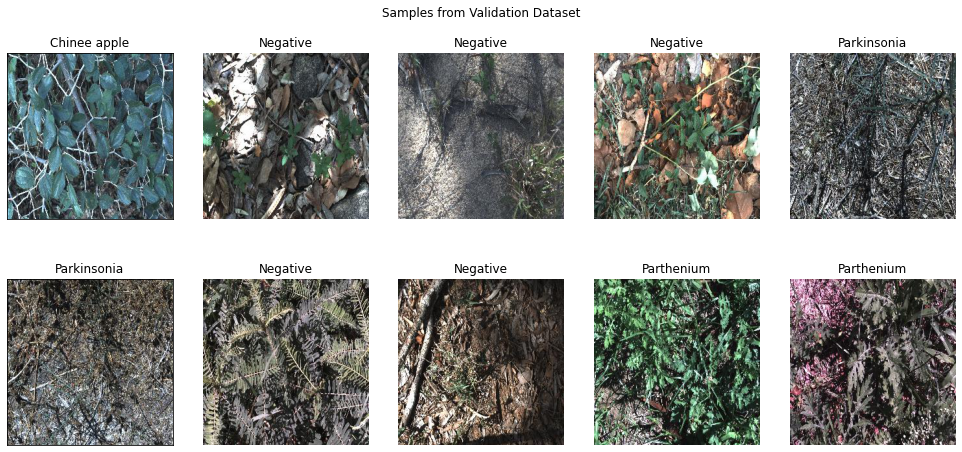

In [22]:
vz.plot_images_from_ds(val_ds,"Samples from Validation Dataset",species_names)

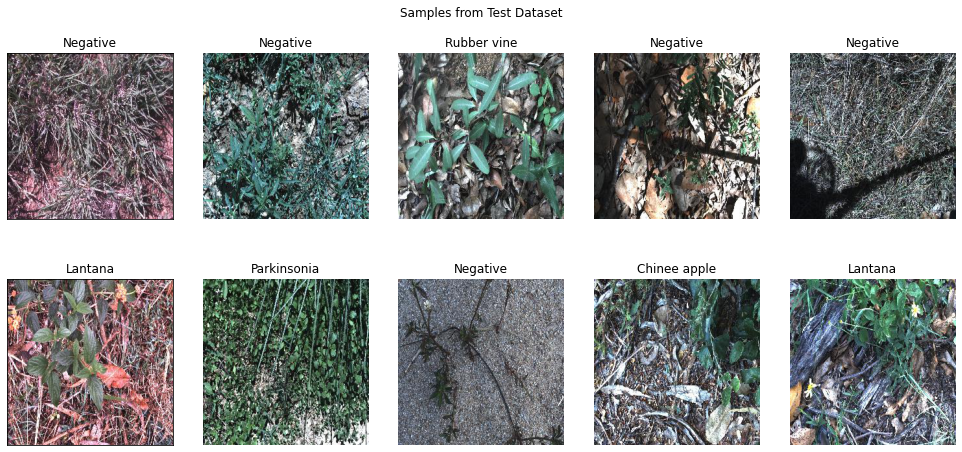

In [23]:
vz.plot_images_from_ds(test_ds,"Samples from Test Dataset",species_names)

###Model Creation

1. We will use ResNet50 trained on ImageNet as the base model.

2. We will Add two Linear Dense layers of size 1024 and 512 to the Head of the base Model with Relu activation 

3. Finally Add a Dense Layer with Softmax activation for Prediction 

4. The Image size for this dataset is 256 x256 . We make it 224 x 224 before feeding to the base model using a lambda layer or resize to 224 x 224 when the creating the Dataset itself . For this iteration we will use a lambda layer to cut a 224x224 patch from the 256x256 image before feeding to ResNet50 backbone 


### Import Required TF modules for model creation 

In [24]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D ,Input,Conv2D,MaxPool2D,Lambda
import tensorflow as tf

### Define and compile model 
Compile model with SGD optimizer using a learning rate of 0.01 and Categorical Cross Entropy as loss function  ( the labels are one-hot encoded while creating Dataset .If not we could use 'Sparse Categorical Cross Entropy') . 

We may also need to revisit the loss function and the model prediction layer to see if we can deal in a better manner with the imbalance caused by the disproportionately large number of Negative samples 

For initial training run , the base model layers are frozen 

In [25]:
img_size=256
  
input_layer=Input(shape=(img_size,img_size,3))
inp1=Lambda(lambda x:tfm.random_crop(x))(input_layer) # crop image to 224 x224 
base_model=ResNet50(weights='imagenet',include_top=False,input_tensor=inp1)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add two fully-connected layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(512, activation='relu')(x)
# and a softmax layer
predictions = Dense(ds.num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Resnet50 layers
for layer in base_model.layers:
    layer.trainable = False

opt=SGD(lr=0.01,momentum=0.9,nesterov=True)
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])


94773248/94765736 [==============================] - 0s 0us/step


### Print Model summary 

In [26]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
_______________________________________________________________________________________

### Model Checkpoint Callback for saving model with best accuracy 
Define a modelCheckpoint monitoring validation accuracy so that we can save the model with best validation accuracy 

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
 
model_cpt=ModelCheckpoint(filepath='/gdrive/My Drive/LiveAI/AgriAI/best_agri_model.h5', 
                          verbose=1, save_best_only=True,monitor='val_accuracy',mode='auto')

### train the model for 80 epochs

In [28]:
batch_size=ds.batch_size
EPOCHS=80
callback_list=[model_cpt]
model_history=model.fit(train_ds, epochs=EPOCHS, 
                        steps_per_epoch=np.ceil(len(train_df1)/batch_size), 
                    validation_data=val_ds,
                    validation_steps=np.ceil(len(val_df)/batch_size), 
                    shuffle=True,callbacks=callback_list,verbose=1)


Epoch 1/80
83/83 [==============================] - ETA: 0s - loss: 1.1263 - accuracy: 0.6257WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0508s vs `on_test_batch_end` time: 0.3135s). Check your callbacks.

Epoch 00001: val_accuracy improved from -inf to 0.74442, saving model to /gdrive/My Drive/LiveAI/AgriAI/best_agri_model.h5
83/83 [==============================] - 55s 659ms/step - loss: 1.1263 - accuracy: 0.6257 - val_loss: 0.7449 - val_accuracy: 0.7444
Epoch 2/80
83/83 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.7308
Epoch 00002: val_accuracy improved from 0.74442 to 0.76897, saving model to /gdrive/My Drive/LiveAI/AgriAI/best_agri_model.h5
83/83 [==============================] - 56s 679ms/step - loss: 0.7541 - accuracy: 0.7308 - val_loss: 0.6374 - val_accuracy: 0.7690
Epoch 3/80
83/83 [==============================] - ETA: 0s - loss: 0.6514 - accuracy: 0.7672
Epoch 00003: val_accuracy improv

In [29]:
model_history

### Plot training history 

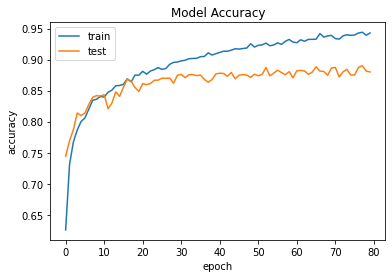

In [30]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

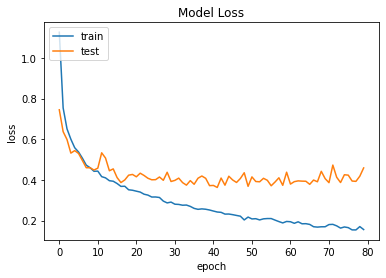

In [31]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### The accuracy as well as loss start diverging at about the 18th Epoch .  We could run a second iteration where we reduce the learning rate after the 20th, 40th and 60th epochs . Also we should follow up with fine tuning by unfreezing some of the base model layers and training with very low learning rate. We should also be training for a longer training run than just 80 epochs 

### Save a copy of the model in google Drive 

In [33]:
model.save('/gdrive/My Drive/LiveAI/AgriAI/agri_model2.h5')

### Evaluate Model with test data 

In [34]:
results=model.evaluate(test_ds,steps=np.ceil(len(test_df)/batch_size))


28/28 [==============================] - 19s 672ms/step - loss: 0.4464 - accuracy: 0.8825


### Print Evaluation Results 

In [35]:
print(results)

[0.44643107056617737, 0.8825334906578064]


#### Model now has a 88% accuracy for the Test set 

### Plot confusion matrix for test dataset

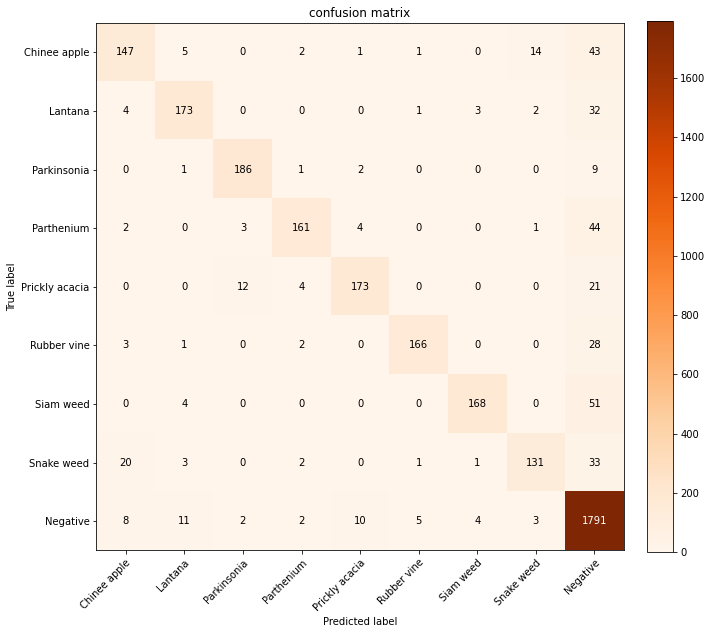

In [36]:
num_steps=np.ceil(len(test_df)/batch_size)
total_samples=len(test_df)
vz.plot_confusion_matrix(model,test_ds,num_steps,total_samples,list(species_names.values()))

From the confusion matrix, we can see that the model gets confused between Chinee Apple and Snake Weed. And a significant % of the weed classes are wrongly predicted as the Negative class. 